# Analysis of Clonesig results on the TCGA
## Pancancer analysis

In [1]:
%matplotlib inline

import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.patches import Patch
import seaborn as sns
import numpy as np
import pandas as pd
import os
from statsmodels.stats.multitest import multipletests
from lifelines import KaplanMeierFitter
from lifelines.plotting import add_at_risk_counts
import collections
from scipy.stats import chi2_contingency
from lifelines import CoxPHFitter

pd.options.display.max_columns = 200
phd_folder_path = '/Users/JudithAbecassis/Documents/PhD'
os.chdir('{}/TCGA_signatures'.format(phd_folder_path))
import warnings
warnings.filterwarnings("ignore")

In [2]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')

To have a first look at data, we look how many clones were found by Clonesig for the public and protected input SNVs.

In [4]:
clonesig_res = pd.read_csv('20190824_tcga_results_survival_restr.csv', sep='\t')
clonesig_res = clonesig_res.assign(survival_days_6y=clonesig_res.survival_days)
clonesig_res = clonesig_res.assign(binary_vital_status_6y=clonesig_res.binary_vital_status)
clonesig_res = clonesig_res.assign(binary_vital_status_15y=clonesig_res.binary_vital_status)
clonesig_res = clonesig_res.assign(survival_months_15y=(clonesig_res.survival_days/30.5))


clonesig_res.loc[(clonesig_res.survival_days>=6*365)&(clonesig_res.binary_vital_status==1), 'binary_vital_status_6y'] = 0
clonesig_res.loc[clonesig_res.survival_days>=6*365, 'survival_days_6y'] = 6*365

clonesig_res.loc[(clonesig_res.survival_days>=15*365)&(clonesig_res.binary_vital_status==1), 'binary_vital_status_15y'] = 0
clonesig_res.loc[clonesig_res.survival_days>=15*365, 'survival_months_15y'] = 15*365/30.5


In [4]:
clonesig_res[clonesig_res.mutation_set=='public'].nb_clones.value_counts()

1    4061
2    3940
3     810
4     122
5      14
6       7
Name: nb_clones, dtype: int64

In [5]:
clonesig_res[clonesig_res.mutation_set=='protected'].nb_clones.value_counts()

2    4823
1    2396
3    1435
4     262
5      35
6       2
7       1
Name: nb_clones, dtype: int64

Then we look at survival curves for the whole TCGA, first distinguishing 1 or 2 clones and more, then 1, 2, and 3 clones and more, and finally 1, 2 clones with no significant signature change, or 2 clones with a significant signature change, for the protected input SNVS

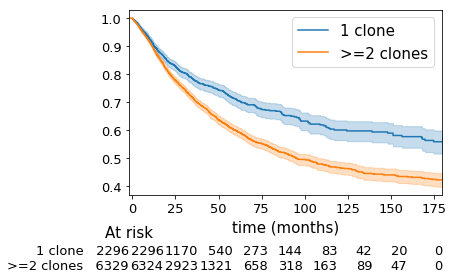

In [5]:

clonesig_res_all_protected = clonesig_res[(clonesig_res.mutation_set=='protected')]
kmf1 = KaplanMeierFitter()
kmf2 = KaplanMeierFitter()

ix1 = (clonesig_res_all_protected[clonesig_res_all_protected.nb_clones==1].index)
ix2 = (clonesig_res_all_protected[clonesig_res_all_protected.nb_clones!=1].index)

kmf1.fit(clonesig_res_all_protected.survival_months_15y[ix1], clonesig_res_all_protected.binary_vital_status_15y[ix1], label='1 clone')
ax = kmf1.plot()

kmf2.fit(clonesig_res_all_protected.survival_months_15y[ix2], clonesig_res_all_protected.binary_vital_status_15y[ix2], label='>=2 clones')
ax = kmf2.plot(ax=ax)


ax.legend(fontsize=15)
ax.tick_params(axis="x", labelsize=13)
ax.tick_params(axis="y", labelsize=13)
ax.set_xlabel('time (months)', fontsize=15)

add_at_risk_counts(kmf1, kmf2, ax=ax)
fig = plt.gcf()
fig.axes[1].tick_params(axis="x", labelsize=13)
fig.axes[1].set_xlabel('At risk', fontsize=15)
plt.savefig('20190801_paper_figures/nb_clones_2_protected_survival_tcga.pdf', bbox_inches='tight')


In [42]:



clonesig_res_all_protected = clonesig_res[(clonesig_res.mutation_set=='protected')]
clonesig_res_all_protected = clonesig_res_all_protected.assign(one_clone=0)
clonesig_res_all_protected = clonesig_res_all_protected.assign(two_clones_more=0)

clonesig_res_all_protected.loc[(clonesig_res_all_protected.nb_clones==1), 'one_clone'] = 1
clonesig_res_all_protected.loc[(clonesig_res_all_protected.nb_clones!=1), 'two_clones_more'] = 1
#clonesig_res_all_protected[['binary_vital_status_15y', 'survival_months_15y', 'one_clone', 'two_clones_more']].to_csv('tmp/tcga_survival_one_two_clones.csv', index=False, sep='\t')


cph = CoxPHFitter()
cph.fit(clonesig_res_all_protected[['binary_vital_status_15y', 'survival_months_15y', 'two_clones_more']], duration_col='survival_months_15y', event_col='binary_vital_status_15y', show_progress=True)

cph.summary




Convergence completed after 4 iterations.


,coef,exp(coef),se(coef),z,p,lower 0.95,upper 0.95
two_clones_more,0.253068,1.287971,0.045016,5.621687,1.891019e-08,0.164818,0.341318


Text(0,-0.225,'At risk')

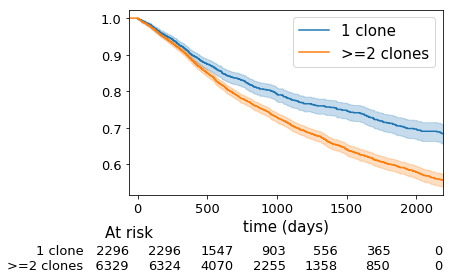

In [6]:


sns.set_context(font_scale=2.5)
clonesig_res_all_protected = clonesig_res[(clonesig_res.mutation_set=='protected')]
kmf1 = KaplanMeierFitter()
kmf2 = KaplanMeierFitter()

ix1 = (clonesig_res_all_protected[clonesig_res_all_protected.nb_clones==1].index)
ix2 = (clonesig_res_all_protected[clonesig_res_all_protected.nb_clones!=1].index)

kmf1.fit(clonesig_res_all_protected.survival_days_6y[ix1], clonesig_res_all_protected.binary_vital_status_6y[ix1], label='1 clone')
ax = kmf1.plot()

kmf2.fit(clonesig_res_all_protected.survival_days_6y[ix2], clonesig_res_all_protected.binary_vital_status_6y[ix2], label='>=2 clones')
ax = kmf2.plot(ax=ax)


ax.legend(fontsize=15)
ax.tick_params(axis="x", labelsize=13)
ax.tick_params(axis="y", labelsize=13)
ax.set_xlabel('time (days)', fontsize=15)

add_at_risk_counts(kmf1, kmf2, ax=ax)
fig = plt.gcf()
fig.axes[1].tick_params(axis="x", labelsize=13)
fig.axes[1].set_xlabel('At risk', fontsize=15)

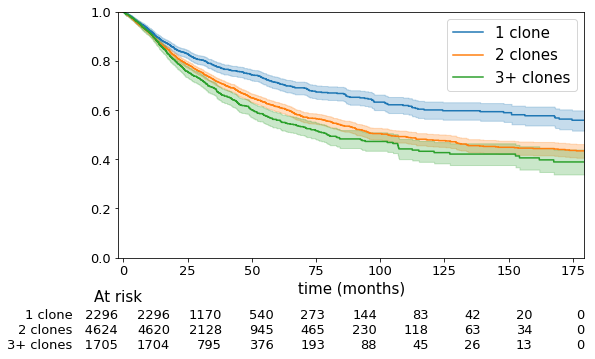

In [19]:
fig, ax = plt.subplots(figsize=(8, 5))
clonesig_res_all_protected = clonesig_res[(clonesig_res.mutation_set=='protected')]
kmf1 = KaplanMeierFitter()
kmf2 = KaplanMeierFitter()
kmf3 = KaplanMeierFitter()

ix1 = (clonesig_res_all_protected[clonesig_res_all_protected.nb_clones==1].index)
ix2 = (clonesig_res_all_protected[clonesig_res_all_protected.nb_clones==2].index)
ix3 = (clonesig_res_all_protected[clonesig_res_all_protected.nb_clones>=3].index)

kmf1.fit(clonesig_res_all_protected.survival_months_15y[ix1], clonesig_res_all_protected.binary_vital_status_15y[ix1], label='1 clone')
ax = kmf1.plot(ax=ax)

kmf2.fit(clonesig_res_all_protected.survival_months_15y[ix2], clonesig_res_all_protected.binary_vital_status_15y[ix2], label='2 clones')
ax = kmf2.plot(ax=ax)


kmf3.fit(clonesig_res_all_protected.survival_months_15y[ix3], clonesig_res_all_protected.binary_vital_status_15y[ix3], label='3+ clones')
ax = kmf3.plot(ax=ax)

ax.legend(fontsize=15)
ax.tick_params(axis="x", labelsize=13)
ax.tick_params(axis="y", labelsize=13)
ax.set_xlabel('time (months)', fontsize=15)

add_at_risk_counts(kmf1, kmf2, kmf3, ax=ax)
fig = plt.gcf()
fig.axes[1].tick_params(axis="x", labelsize=13)
fig.axes[1].set_xlabel('At risk', fontsize=15)
ax.set_ylim([0,1])
plt.savefig('20190801_paper_figures/nb_clones_3_protected_survival_tcga.pdf', bbox_inches='tight')


In [39]:



clonesig_res_all_protected = clonesig_res[(clonesig_res.mutation_set=='protected')]
clonesig_res_all_protected = clonesig_res_all_protected.assign(one_clone=0)
clonesig_res_all_protected = clonesig_res_all_protected.assign(two_clones=0)
clonesig_res_all_protected = clonesig_res_all_protected.assign(three_clones_more=0)

clonesig_res_all_protected.loc[(clonesig_res_all_protected.nb_clones==1), 'one_clone'] = 1
clonesig_res_all_protected.loc[(clonesig_res_all_protected.nb_clones==2), 'two_clones'] = 1
clonesig_res_all_protected.loc[(clonesig_res_all_protected.nb_clones>2), 'three_clones_more'] = 1
#clonesig_res_all_protected[['binary_vital_status_15y', 'survival_months_15y', 'one_clone', 'two_clones', 'three_clones_more']].to_csv('tmp/tcga_survival_one_two_three_clones.csv', sep='\t', index=False)

cph = CoxPHFitter()
cph.fit(clonesig_res_all_protected[['binary_vital_status_15y', 'survival_months_15y', 'two_clones', 'three_clones_more']], duration_col='survival_months_15y', event_col='binary_vital_status_15y', show_progress=True)

cph.summary


Convergence completed after 4 iterations.


,coef,exp(coef),se(coef),z,p,lower 0.95,upper 0.95
two_clones,0.221647,1.248131,0.046881,4.727889,2.268664e-06,0.129742,0.313552
three_clones_more,0.343210,1.409464,0.057248,5.995095,2.033668e-09,0.230980,0.455439


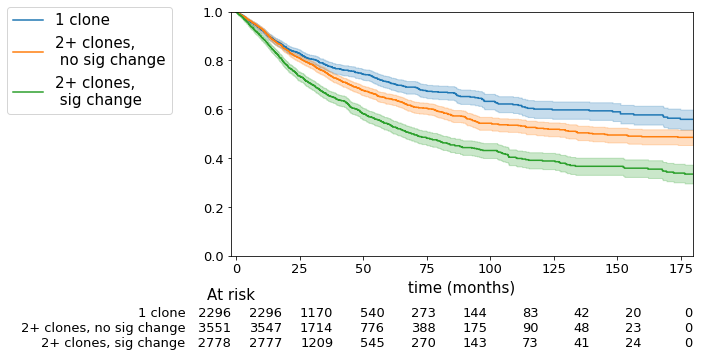

In [18]:
fig, ax = plt.subplots(figsize=(9, 5))
clonesig_res_all_protected = clonesig_res[(clonesig_res.mutation_set=='protected')]
kmf1 = KaplanMeierFitter()
kmf2 = KaplanMeierFitter()
kmf3 = KaplanMeierFitter()

ix1 = (clonesig_res_all_protected[clonesig_res_all_protected.nb_clones==1].index)
ix2 = (clonesig_res_all_protected[(clonesig_res_all_protected.nb_clones>=2)&(clonesig_res_all_protected.pval>0.05)].index)
ix3 = (clonesig_res_all_protected[(clonesig_res_all_protected.nb_clones>=2)&(clonesig_res_all_protected.pval<=0.05)].index)

kmf1.fit(clonesig_res_all_protected.survival_months_15y[ix1], clonesig_res_all_protected.binary_vital_status_15y[ix1], label='1 clone')
ax = kmf1.plot(ax=ax)

kmf2.fit(clonesig_res_all_protected.survival_months_15y[ix2], clonesig_res_all_protected.binary_vital_status_15y[ix2], label='2+ clones, no sig change')
ax = kmf2.plot(ax=ax)



kmf3.fit(clonesig_res_all_protected.survival_months_15y[ix3], clonesig_res_all_protected.binary_vital_status_15y[ix3], label='2+ clones, sig change')
ax = kmf3.plot(ax=ax)

ax.legend(fontsize=15, loc=2, bbox_to_anchor=(-0.5,1.05), labels=['1 clone', '2+ clones,\n no sig change', '2+ clones,\n sig change'])
ax.tick_params(axis="x", labelsize=13)
ax.tick_params(axis="y", labelsize=13)
ax.set_xlabel('time (months)', fontsize=15)
ax.set_ylim([0,1])
add_at_risk_counts(kmf1, kmf2, kmf3, ax=ax)
fig = plt.gcf()
fig.axes[1].tick_params(axis="x", labelsize=13)
fig.axes[1].set_xlabel('At risk', fontsize=15)
plt.savefig('20190801_paper_figures/nb_clones_2_sig_protected_survival_tcga.pdf', bbox_inches='tight')


In [40]:



clonesig_res_all_protected = clonesig_res[(clonesig_res.mutation_set=='protected')]
clonesig_res_all_protected = clonesig_res_all_protected.assign(one_clone=0)
clonesig_res_all_protected = clonesig_res_all_protected.assign(two_clones_nochange=0)
clonesig_res_all_protected = clonesig_res_all_protected.assign(two_clones_change=0)

clonesig_res_all_protected.loc[(clonesig_res_all_protected.nb_clones==1), 'one_clone'] = 1
clonesig_res_all_protected.loc[(clonesig_res_all_protected.nb_clones>=2)&(clonesig_res_all_protected.pval>0.05), 'two_clones_nochange'] = 1
clonesig_res_all_protected.loc[(clonesig_res_all_protected.nb_clones>=2)&(clonesig_res_all_protected.pval<=0.05), 'two_clones_change'] = 1
clonesig_res_all_protected[['binary_vital_status_15y', 'survival_months_15y', 'one_clone', 'two_clones_nochange', 'two_clones_change']].to_csv('tmp/tcga_survival_one_two_change_clones.csv', sep='\t', index=False)

cph = CoxPHFitter()
cph.fit(clonesig_res_all_protected[['binary_vital_status_15y', 'survival_months_15y', 'two_clones_nochange', 'two_clones_change']], duration_col='survival_months_15y', event_col='binary_vital_status_15y', show_progress=True)

cph.summary


Convergence completed after 4 iterations.


,coef,exp(coef),se(coef),z,p,lower 0.95,upper 0.95
two_clones_nochange,0.132572,1.141761,0.049253,2.691659,7.109765e-03,0.036017,0.229127
two_clones_change,0.412953,1.511274,0.050595,8.161993,3.295404e-16,0.313768,0.512139


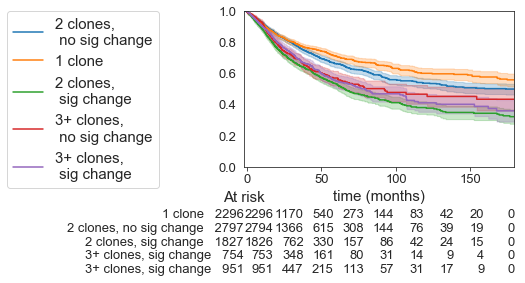

In [40]:
clonesig_res_all_protected = clonesig_res[(clonesig_res.mutation_set=='protected')]
kmf1 = KaplanMeierFitter()
kmf2 = KaplanMeierFitter()
kmf3 = KaplanMeierFitter()
kmf4 = KaplanMeierFitter()
kmf5 = KaplanMeierFitter()

ix1 = (clonesig_res_all_protected[clonesig_res_all_protected.nb_clones==1].index)
ix2 = (clonesig_res_all_protected[(clonesig_res_all_protected.nb_clones==2)&(clonesig_res_all_protected.pval>0.05)].index)
ix3 = (clonesig_res_all_protected[(clonesig_res_all_protected.nb_clones==2)&(clonesig_res_all_protected.pval<=0.05)].index)
ix4 = (clonesig_res_all_protected[(clonesig_res_all_protected.nb_clones>=3)&(clonesig_res_all_protected.pval>0.05)].index)
ix5 = (clonesig_res_all_protected[(clonesig_res_all_protected.nb_clones>=3)&(clonesig_res_all_protected.pval<=0.05)].index)

kmf2.fit(clonesig_res_all_protected.survival_months_15y[ix2], clonesig_res_all_protected.binary_vital_status_15y[ix2], label='2 clones, no sig change')
ax = kmf2.plot()

kmf1.fit(clonesig_res_all_protected.survival_months_15y[ix1], clonesig_res_all_protected.binary_vital_status_15y[ix1], label='1 clone')
ax = kmf1.plot(ax=ax)

kmf3.fit(clonesig_res_all_protected.survival_months_15y[ix3], clonesig_res_all_protected.binary_vital_status_15y[ix3], label='2 clones, sig change')
ax = kmf3.plot(ax=ax)

kmf4.fit(clonesig_res_all_protected.survival_months_15y[ix4], clonesig_res_all_protected.binary_vital_status_15y[ix4], label='3+ clones, sig change')
ax = kmf4.plot(ax=ax)

kmf5.fit(clonesig_res_all_protected.survival_months_15y[ix5], clonesig_res_all_protected.binary_vital_status_15y[ix5], label='3+ clones, sig change')
ax = kmf5.plot(ax=ax)

ax.legend(fontsize=15, loc=2, bbox_to_anchor=(-0.9,1.05), labels=['2 clones,\n no sig change', '1 clone', '2 clones,\n sig change', '3+ clones,\n no sig change', '3+ clones,\n sig change'])
ax.tick_params(axis="x", labelsize=13)
ax.tick_params(axis="y", labelsize=13)
ax.set_xlabel('time (months)', fontsize=15)
ax.set_ylim([0,1])
add_at_risk_counts(kmf1, kmf2, kmf3, kmf4, kmf5, ax=ax)
fig = plt.gcf()
fig.axes[1].tick_params(axis="x", labelsize=13)
fig.axes[1].set_xlabel('At risk', fontsize=15)
plt.savefig('20190801_paper_figures/nb_clones_3_sig_protected_survival_tcga.pdf', bbox_inches='tight')


In [41]:



clonesig_res_all_protected = clonesig_res[(clonesig_res.mutation_set=='protected')]
clonesig_res_all_protected = clonesig_res_all_protected.assign(one_clone=0)
clonesig_res_all_protected = clonesig_res_all_protected.assign(two_clones_nochange=0)
clonesig_res_all_protected = clonesig_res_all_protected.assign(two_clones_change=0)
clonesig_res_all_protected = clonesig_res_all_protected.assign(three_clones_nochange=0)
clonesig_res_all_protected = clonesig_res_all_protected.assign(three_clones_change=0)

clonesig_res_all_protected.loc[(clonesig_res_all_protected.nb_clones==1), 'one_clone'] = 1
clonesig_res_all_protected.loc[(clonesig_res_all_protected.nb_clones==2)&(clonesig_res_all_protected.pval>0.05), 'two_clones_nochange'] = 1
clonesig_res_all_protected.loc[(clonesig_res_all_protected.nb_clones==2)&(clonesig_res_all_protected.pval<=0.05), 'two_clones_change'] = 1
clonesig_res_all_protected.loc[(clonesig_res_all_protected.nb_clones>=3)&(clonesig_res_all_protected.pval>0.05), 'three_clones_nochange'] = 1
clonesig_res_all_protected.loc[(clonesig_res_all_protected.nb_clones>=3)&(clonesig_res_all_protected.pval<=0.05), 'three_clones_change'] = 1



#clonesig_res_all_protected[['binary_vital_status_15y', 'survival_months_15y', 'one_clone', 'two_clones_nochange', 'two_clones_change', 'three_clones_nochange', 'three_clones_change']].to_csv('tmp/tcga_survival_one_two_three_change_clones.csv', sep='\t', index=False)
cph = CoxPHFitter()
cph.fit(clonesig_res_all_protected[['binary_vital_status_15y', 'survival_months_15y', 'two_clones_nochange', 'two_clones_change', 'three_clones_nochange', 'three_clones_change']], duration_col='survival_months_15y', event_col='binary_vital_status_15y', show_progress=True)

cph.summary



Convergence completed after 4 iterations.


,coef,exp(coef),se(coef),z,p,lower 0.95,upper 0.95
two_clones_nochange,0.078466,1.081627,0.051715,1.517291,1.291931e-01,-0.022915,0.179847
two_clones_change,0.448490,1.565946,0.055040,8.148479,3.685300e-16,0.340591,0.556390
three_clones_nochange,0.348569,1.417038,0.073796,4.723422,2.319087e-06,0.203900,0.493237
three_clones_change,0.342604,1.408611,0.068007,5.037807,4.708955e-07,0.209284,0.475924


Then we look at survival curves for the whole TCGA, first distinguishing 1 or 2 clones and more, then 1, 2, and 3 clones and more, and finally 1, 2 clones with no significant signature change, or 2 clones with a significant signature change, for the **public** input SNVS

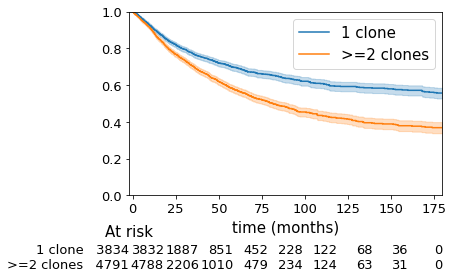

In [20]:
clonesig_res_all_protected = clonesig_res[(clonesig_res.mutation_set=='public')]
kmf1 = KaplanMeierFitter()
kmf2 = KaplanMeierFitter()

ix1 = (clonesig_res_all_protected[clonesig_res_all_protected.nb_clones==1].index)
ix2 = (clonesig_res_all_protected[clonesig_res_all_protected.nb_clones!=1].index)


kmf1.fit(clonesig_res_all_protected.survival_months_15y[ix1], clonesig_res_all_protected.binary_vital_status_15y[ix1], label='1 clone')
ax = kmf1.plot()

kmf2.fit(clonesig_res_all_protected.survival_months_15y[ix2], clonesig_res_all_protected.binary_vital_status_15y[ix2], label='>=2 clones')
ax = kmf2.plot(ax=ax)




ax.legend(fontsize=15)
ax.tick_params(axis="x", labelsize=13)
ax.tick_params(axis="y", labelsize=13)
ax.set_xlabel('time (months)', fontsize=15)
ax.set_ylim([0,1])
add_at_risk_counts(kmf1, kmf2, ax=ax)
fig = plt.gcf()
fig.axes[1].tick_params(axis="x", labelsize=13)
fig.axes[1].set_xlabel('At risk', fontsize=15)
plt.savefig('20190801_paper_figures/nb_clones_2_public_survival_tcga.pdf', bbox_inches='tight')


In [43]:



clonesig_res_all_protected = clonesig_res[(clonesig_res.mutation_set=='public')]
clonesig_res_all_protected = clonesig_res_all_protected.assign(one_clone=0)
clonesig_res_all_protected = clonesig_res_all_protected.assign(two_clones_more=0)

clonesig_res_all_protected.loc[(clonesig_res_all_protected.nb_clones==1), 'one_clone'] = 1
clonesig_res_all_protected.loc[(clonesig_res_all_protected.nb_clones!=1), 'two_clones_more'] = 1
#clonesig_res_all_protected[['binary_vital_status_15y', 'survival_months_15y', 'one_clone', 'two_clones_more']].to_csv('tmp/public_tcga_survival_one_two_clones.csv', index=False, sep='\t')
cph = CoxPHFitter()
cph.fit(clonesig_res_all_protected[['binary_vital_status_15y', 'survival_months_15y', 'two_clones_more']], duration_col='survival_months_15y', event_col='binary_vital_status_15y', show_progress=True)

cph.summary


Convergence completed after 4 iterations.


,coef,exp(coef),se(coef),z,p,lower 0.95,upper 0.95
two_clones_more,0.3407,1.405931,0.038463,8.857822,8.159285e-19,0.265297,0.416103


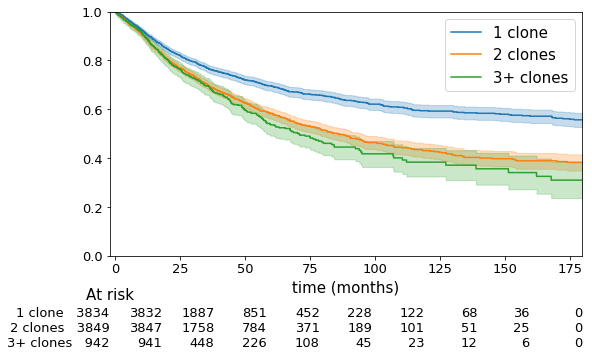

In [23]:
fig, ax = plt.subplots(figsize=(8, 5))
clonesig_res_all_protected = clonesig_res[(clonesig_res.mutation_set=='public')]
kmf1 = KaplanMeierFitter()
kmf2 = KaplanMeierFitter()
kmf3 = KaplanMeierFitter()

ix1 = (clonesig_res_all_protected[clonesig_res_all_protected.nb_clones==1].index)
ix2 = (clonesig_res_all_protected[clonesig_res_all_protected.nb_clones==2].index)
ix3 = (clonesig_res_all_protected[clonesig_res_all_protected.nb_clones>=3].index)

kmf1.fit(clonesig_res_all_protected.survival_months_15y[ix1], clonesig_res_all_protected.binary_vital_status_15y[ix1], label='1 clone')
ax = kmf1.plot(ax=ax)

kmf2.fit(clonesig_res_all_protected.survival_months_15y[ix2], clonesig_res_all_protected.binary_vital_status_15y[ix2], label='2 clones')
ax = kmf2.plot(ax=ax)



kmf3.fit(clonesig_res_all_protected.survival_months_15y[ix3], clonesig_res_all_protected.binary_vital_status_15y[ix3], label='3+ clones')
ax = kmf3.plot(ax=ax)

ax.legend(fontsize=15)
ax.tick_params(axis="x", labelsize=13)
ax.tick_params(axis="y", labelsize=13)
ax.set_xlabel('time (months)', fontsize=15)
ax.set_ylim([0,1])
add_at_risk_counts(kmf1, kmf2, kmf3, ax=ax)
fig = plt.gcf()
fig.axes[1].tick_params(axis="x", labelsize=13)
fig.axes[1].set_xlabel('At risk', fontsize=15)
plt.savefig('20190801_paper_figures/nb_clones_3_public_survival_tcga.pdf', bbox_inches='tight')


In [44]:



clonesig_res_all_protected = clonesig_res[(clonesig_res.mutation_set=='public')]
clonesig_res_all_protected = clonesig_res_all_protected.assign(one_clone=0)
clonesig_res_all_protected = clonesig_res_all_protected.assign(two_clones=0)
clonesig_res_all_protected = clonesig_res_all_protected.assign(three_clones_more=0)

clonesig_res_all_protected.loc[(clonesig_res_all_protected.nb_clones==1), 'one_clone'] = 1
clonesig_res_all_protected.loc[(clonesig_res_all_protected.nb_clones==2), 'two_clones'] = 1
clonesig_res_all_protected.loc[(clonesig_res_all_protected.nb_clones>2), 'three_clones_more'] = 1
#clonesig_res_all_protected[['binary_vital_status_15y', 'survival_months_15y', 'one_clone', 'two_clones', 'three_clones_more']].to_csv('tmp/public_tcga_survival_one_two_three_clones.csv', sep='\t', index=False)

cph = CoxPHFitter()
cph.fit(clonesig_res_all_protected[['binary_vital_status_15y', 'survival_months_15y', 'two_clones', 'three_clones_more']], duration_col='survival_months_15y', event_col='binary_vital_status_15y', show_progress=True)

cph.summary


Convergence completed after 4 iterations.


,coef,exp(coef),se(coef),z,p,lower 0.95,upper 0.95
two_clones,0.319243,1.376085,0.040372,7.907554,2.624961e-15,0.240098,0.398388
three_clones_more,0.431842,1.540091,0.062408,6.919623,4.528456e-12,0.309497,0.554187


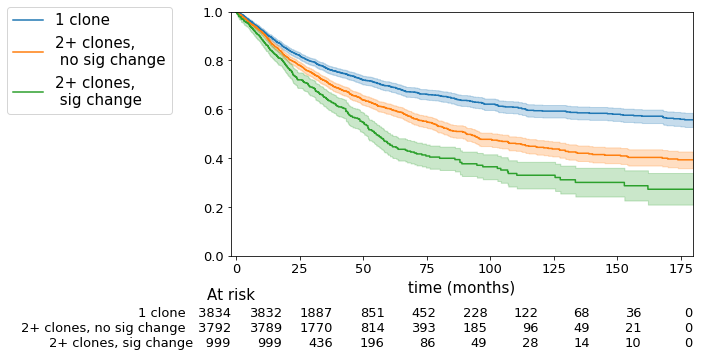

In [25]:
fig, ax = plt.subplots(figsize=(9, 5))
clonesig_res_all_protected = clonesig_res[(clonesig_res.mutation_set=='public')]
kmf1 = KaplanMeierFitter()
kmf2 = KaplanMeierFitter()
kmf3 = KaplanMeierFitter()

ix1 = (clonesig_res_all_protected[clonesig_res_all_protected.nb_clones==1].index)
ix2 = (clonesig_res_all_protected[(clonesig_res_all_protected.nb_clones>=2)&(clonesig_res_all_protected.pval>0.05)].index)
ix3 = (clonesig_res_all_protected[(clonesig_res_all_protected.nb_clones>=2)&(clonesig_res_all_protected.pval<=0.05)].index)

kmf1.fit(clonesig_res_all_protected.survival_months_15y[ix1], clonesig_res_all_protected.binary_vital_status_15y[ix1], label='1 clone')
ax = kmf1.plot(ax=ax)

kmf2.fit(clonesig_res_all_protected.survival_months_15y[ix2], clonesig_res_all_protected.binary_vital_status_15y[ix2], label='2+ clones, no sig change')
ax = kmf2.plot(ax=ax)



kmf3.fit(clonesig_res_all_protected.survival_months_15y[ix3], clonesig_res_all_protected.binary_vital_status_15y[ix3], label='2+ clones, sig change')
ax = kmf3.plot(ax=ax)

ax.legend(fontsize=15, loc=2, bbox_to_anchor=(-0.5,1.05), labels=['1 clone', '2+ clones,\n no sig change', '2+ clones,\n sig change'])
ax.tick_params(axis="x", labelsize=13)
ax.tick_params(axis="y", labelsize=13)
ax.set_xlabel('time (months)', fontsize=15)
ax.set_ylim([0,1])
add_at_risk_counts(kmf1, kmf2, kmf3, ax=ax)
fig = plt.gcf()
fig.axes[1].tick_params(axis="x", labelsize=13)
fig.axes[1].set_xlabel('At risk', fontsize=15)
plt.savefig('20190801_paper_figures/nb_clones_2_sig_public_survival_tcga.pdf', bbox_inches='tight')


In [45]:



clonesig_res_all_protected = clonesig_res[(clonesig_res.mutation_set=='public')]
clonesig_res_all_protected = clonesig_res_all_protected.assign(one_clone=0)
clonesig_res_all_protected = clonesig_res_all_protected.assign(two_clones_nochange=0)
clonesig_res_all_protected = clonesig_res_all_protected.assign(two_clones_change=0)

clonesig_res_all_protected.loc[(clonesig_res_all_protected.nb_clones==1), 'one_clone'] = 1
clonesig_res_all_protected.loc[(clonesig_res_all_protected.nb_clones>=2)&(clonesig_res_all_protected.pval>0.05), 'two_clones_nochange'] = 1
clonesig_res_all_protected.loc[(clonesig_res_all_protected.nb_clones>=2)&(clonesig_res_all_protected.pval<=0.05), 'two_clones_change'] = 1
#clonesig_res_all_protected[['binary_vital_status_15y', 'survival_months_15y', 'one_clone', 'two_clones_nochange', 'two_clones_change']].to_csv('tmp/public_tcga_survival_one_two_change_clones.csv', sep='\t', index=False)
cph = CoxPHFitter()
cph.fit(clonesig_res_all_protected[['binary_vital_status_15y', 'survival_months_15y', 'two_clones_nochange', 'two_clones_change']], duration_col='survival_months_15y', event_col='binary_vital_status_15y', show_progress=True)

cph.summary



Convergence completed after 5 iterations.


,coef,exp(coef),se(coef),z,p,lower 0.95,upper 0.95
two_clones_nochange,0.278701,1.321412,0.040705,6.846800,7.552020e-12,0.198902,0.358499
two_clones_change,0.588757,1.801748,0.059568,9.883795,4.894346e-23,0.471981,0.705534


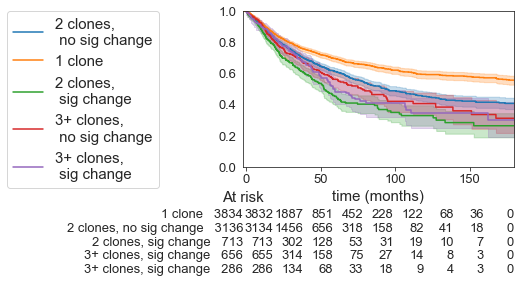

In [45]:
clonesig_res_all_protected = clonesig_res[(clonesig_res.mutation_set=='public')]
kmf1 = KaplanMeierFitter()
kmf2 = KaplanMeierFitter()
kmf3 = KaplanMeierFitter()
kmf4 = KaplanMeierFitter()
kmf5 = KaplanMeierFitter()

ix1 = (clonesig_res_all_protected[clonesig_res_all_protected.nb_clones==1].index)
ix2 = (clonesig_res_all_protected[(clonesig_res_all_protected.nb_clones==2)&(clonesig_res_all_protected.pval>0.05)].index)
ix3 = (clonesig_res_all_protected[(clonesig_res_all_protected.nb_clones==2)&(clonesig_res_all_protected.pval<=0.05)].index)
ix4 = (clonesig_res_all_protected[(clonesig_res_all_protected.nb_clones>=3)&(clonesig_res_all_protected.pval>0.05)].index)
ix5 = (clonesig_res_all_protected[(clonesig_res_all_protected.nb_clones>=3)&(clonesig_res_all_protected.pval<=0.05)].index)

kmf2.fit(clonesig_res_all_protected.survival_months_15y[ix2], clonesig_res_all_protected.binary_vital_status_15y[ix2], label='2 clones, no sig change')
ax = kmf2.plot()

kmf1.fit(clonesig_res_all_protected.survival_months_15y[ix1], clonesig_res_all_protected.binary_vital_status_15y[ix1], label='1 clone')
ax = kmf1.plot(ax=ax)

kmf3.fit(clonesig_res_all_protected.survival_months_15y[ix3], clonesig_res_all_protected.binary_vital_status_15y[ix3], label='2 clones, sig change')
ax = kmf3.plot(ax=ax)

kmf4.fit(clonesig_res_all_protected.survival_months_15y[ix4], clonesig_res_all_protected.binary_vital_status_15y[ix4], label='3+ clones, sig change')
ax = kmf4.plot(ax=ax)

kmf5.fit(clonesig_res_all_protected.survival_months_15y[ix5], clonesig_res_all_protected.binary_vital_status_15y[ix5], label='3+ clones, sig change')
ax = kmf5.plot(ax=ax)

ax.legend(fontsize=15, loc=2, bbox_to_anchor=(-0.9,1.05), labels=['2 clones,\n no sig change', '1 clone', '2 clones,\n sig change', '3+ clones,\n no sig change', '3+ clones,\n sig change'])
ax.tick_params(axis="x", labelsize=13)
ax.tick_params(axis="y", labelsize=13)
ax.set_xlabel('time (months)', fontsize=15)
ax.set_ylim([0,1])
add_at_risk_counts(kmf1, kmf2, kmf3, kmf4, kmf5, ax=ax)
fig = plt.gcf()
fig.axes[1].tick_params(axis="x", labelsize=13)
fig.axes[1].set_xlabel('At risk', fontsize=15)
plt.savefig('20190801_paper_figures/nb_clones_3_sig_public_survival_tcga.pdf', bbox_inches='tight')


In [46]:



clonesig_res_all_protected = clonesig_res[(clonesig_res.mutation_set=='public')]
clonesig_res_all_protected = clonesig_res_all_protected.assign(one_clone=0)
clonesig_res_all_protected = clonesig_res_all_protected.assign(two_clones_nochange=0)
clonesig_res_all_protected = clonesig_res_all_protected.assign(two_clones_change=0)
clonesig_res_all_protected = clonesig_res_all_protected.assign(three_clones_nochange=0)
clonesig_res_all_protected = clonesig_res_all_protected.assign(three_clones_change=0)

clonesig_res_all_protected.loc[(clonesig_res_all_protected.nb_clones==1), 'one_clone'] = 1
clonesig_res_all_protected.loc[(clonesig_res_all_protected.nb_clones==2)&(clonesig_res_all_protected.pval>0.05), 'two_clones_nochange'] = 1
clonesig_res_all_protected.loc[(clonesig_res_all_protected.nb_clones==2)&(clonesig_res_all_protected.pval<=0.05), 'two_clones_change'] = 1
clonesig_res_all_protected.loc[(clonesig_res_all_protected.nb_clones>=3)&(clonesig_res_all_protected.pval>0.05), 'three_clones_nochange'] = 1
clonesig_res_all_protected.loc[(clonesig_res_all_protected.nb_clones>=3)&(clonesig_res_all_protected.pval<=0.05), 'three_clones_change'] = 1



#clonesig_res_all_protected[['binary_vital_status_15y', 'survival_months_15y', 'one_clone', 'two_clones_nochange', 'two_clones_change', 'three_clones_nochange', 'three_clones_change']].to_csv('tmp/public_tcga_survival_one_two_three_change_clones.csv', sep='\t', index=False)
cph = CoxPHFitter()
cph.fit(clonesig_res_all_protected[['binary_vital_status_15y', 'survival_months_15y', 'two_clones_nochange', 'two_clones_change', 'three_clones_nochange', 'three_clones_change']], duration_col='survival_months_15y', event_col='binary_vital_status_15y', show_progress=True)

cph.summary



Convergence completed after 5 iterations.


,coef,exp(coef),se(coef),z,p,lower 0.95,upper 0.95
two_clones_nochange,0.250277,1.284382,0.042717,5.858996,4.656742e-09,0.166536,0.334019
two_clones_change,0.649579,1.914735,0.067944,9.560510,1.171777e-21,0.516382,0.782776
three_clones_nochange,0.425803,1.530820,0.073035,5.830106,5.539230e-09,0.282625,0.568981
three_clones_change,0.455825,1.577475,0.100743,4.524616,6.050523e-06,0.258328,0.653322


Now, one more exploration to see if the difference in survival is found in a cancer-type-specific way. It is not, maybe a problem of sample size and statistical power or Simpson's paradox

## Cancer-type specific survival analysis

ACC
7 58 12
BLCA
90 117 147
BRCA
219 512 200
CESC
42 65 168
CHOL
10 21 4
COADREAD
57 83 318
DLBC
12 12 13
ESCA
39 65 76
GBM
42 83 202
HNSC
129 168 148
KICH
4 21 35
KIRC
78 170 23
KIRP
47 142 53
LGG
101 334 20
LIHC
67 178 102
LUAD
108 108 217
LUSC
140 103 180
MESO
25 48 5
OV
9 180 201
PAAD
57 75 18
PCPG
58 82 1
PRAD
208 232 18
SARC
35 130 45
SKCM
112 101 210
STAD
103 188 127
TGCT
93 30 5
THCA
332 126 9
THYM
73 20 28
UCEC
85 189 213
UCS
2 16 35
UVM
12 65 3


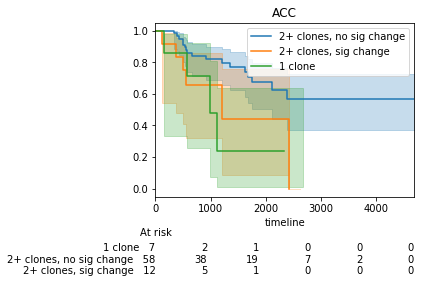

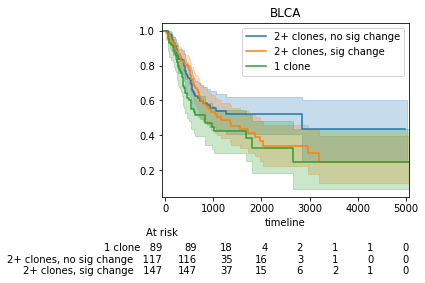

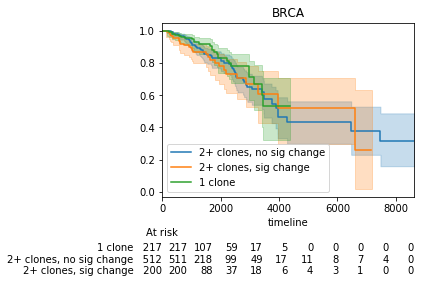

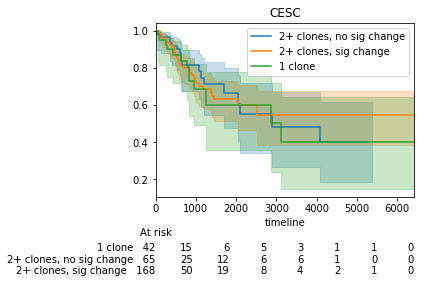

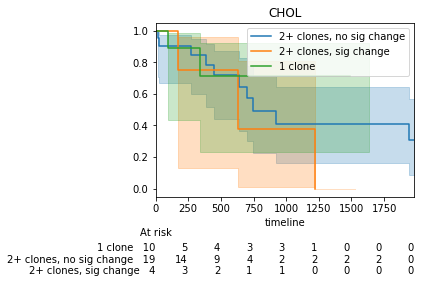

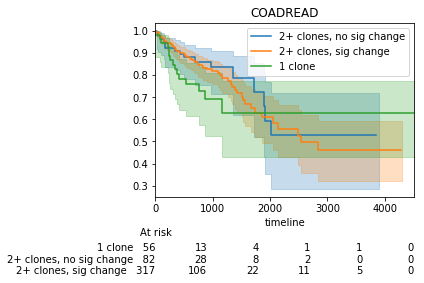

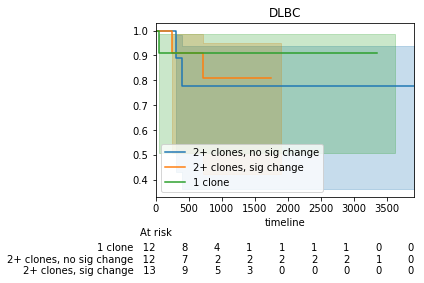

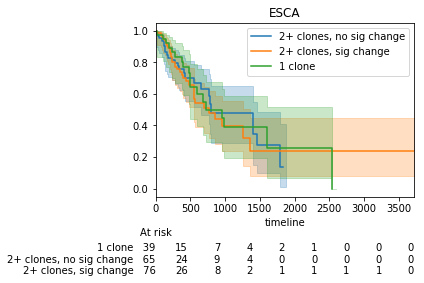

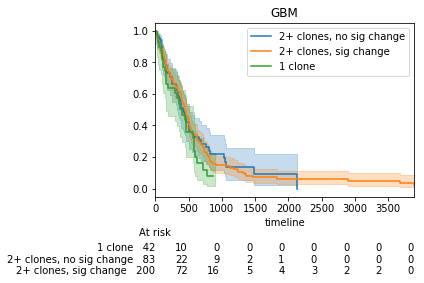

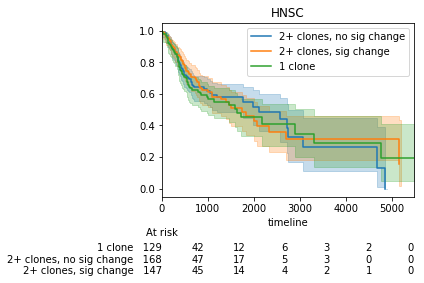

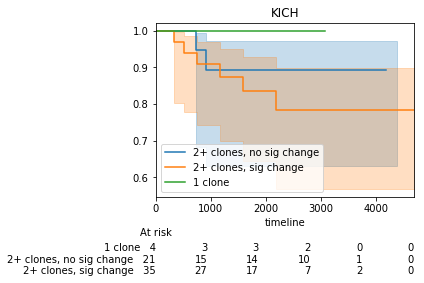

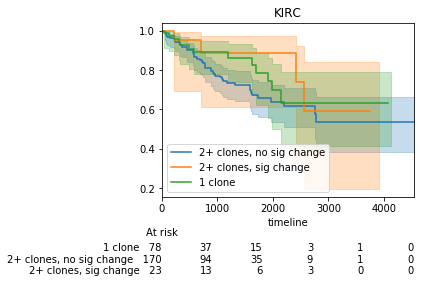

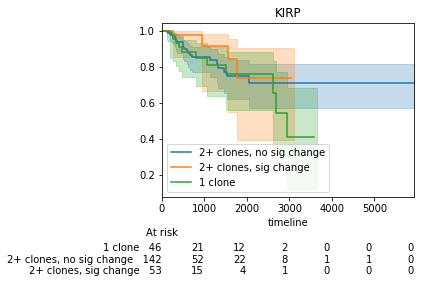

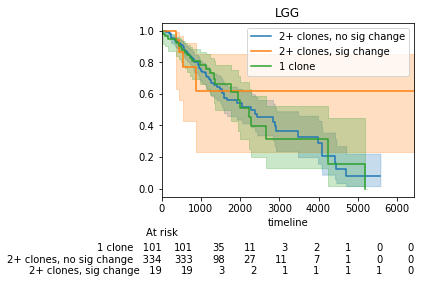

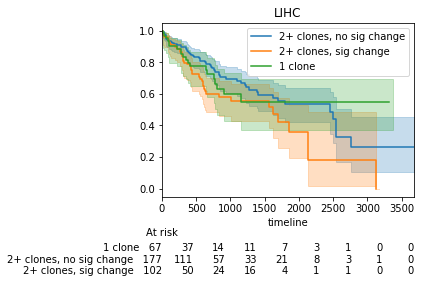

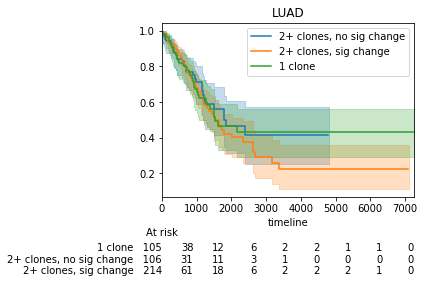

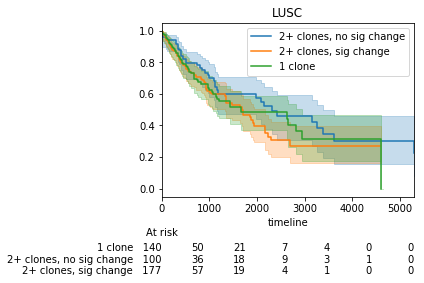

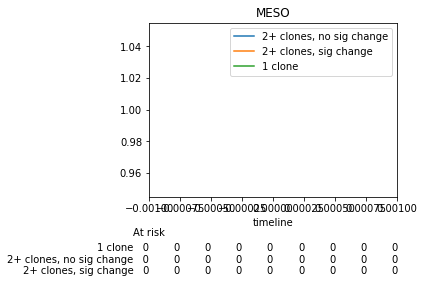

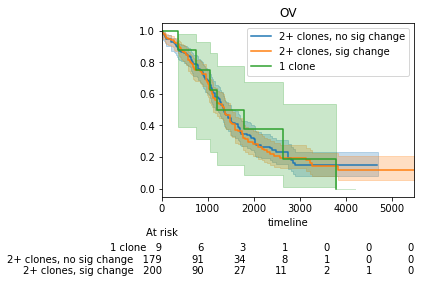

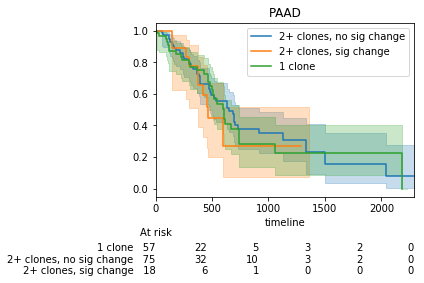

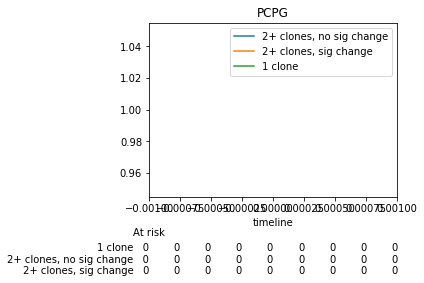

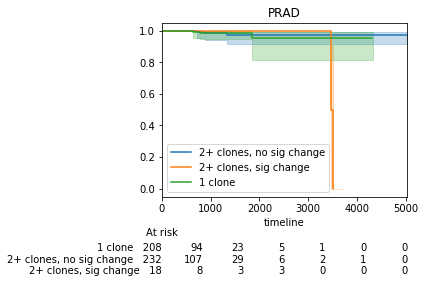

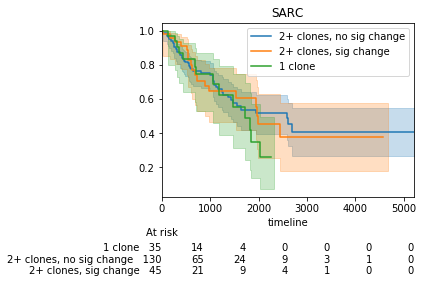

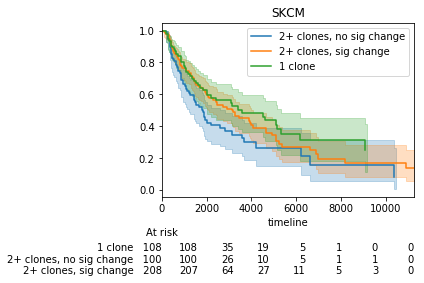

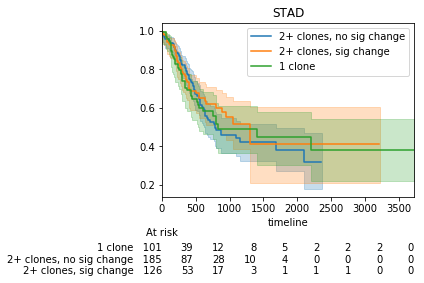

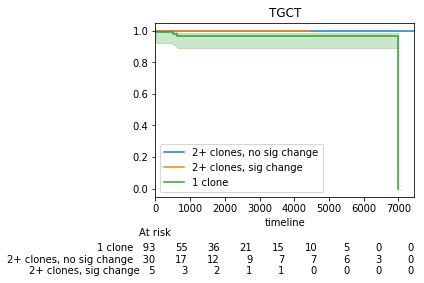

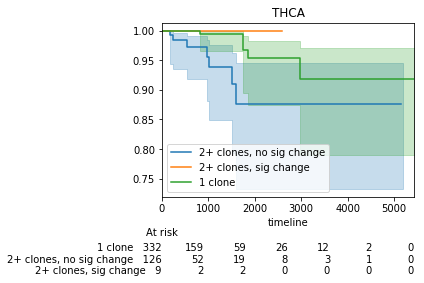

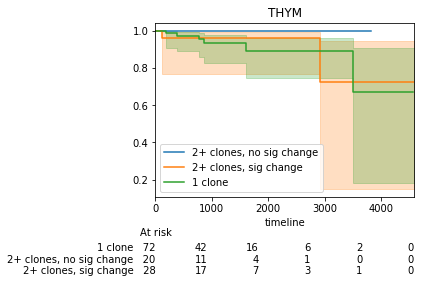

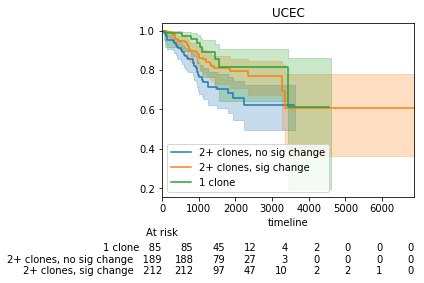

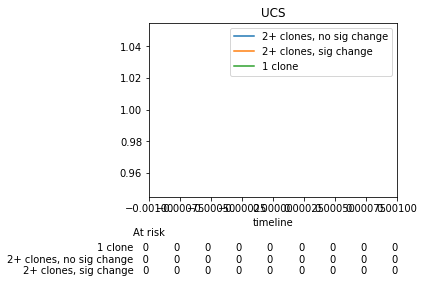

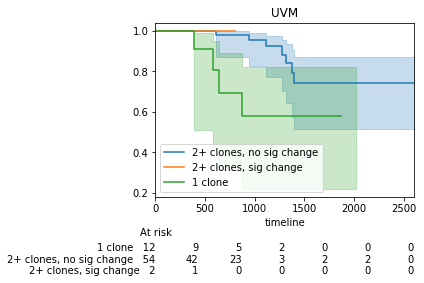

In [13]:
import lifelines
clonesig_res_all_protected = clonesig_res[(clonesig_res.mutation_set=='protected')]

for loc in clonesig_res_all_protected.cancer_loc_x.unique():
    print(loc)
    try:
        figure = plt.figure()
        restr_loc = clonesig_res_all_protected[clonesig_res_all_protected.cancer_loc_x==loc]
        kmf1 = KaplanMeierFitter()
        kmf2 = KaplanMeierFitter()
        kmf3 = KaplanMeierFitter()

        ix1 = (restr_loc[restr_loc.nb_clones==1].index)
        ix2 = (restr_loc[(restr_loc.nb_clones!=1) &(restr_loc.pval>0.05)].index)
        ix3 = (restr_loc[(restr_loc.nb_clones!=1) &(restr_loc.pval<=0.05)].index)
        print(len(ix1), len(ix2), len(ix3))


        kmf2.fit(restr_loc.survival_days[ix2], restr_loc.binary_vital_status[ix2], label='2+ clones, no sig change')
        ax=kmf2.plot()



        kmf3.fit(restr_loc.survival_days[ix3], restr_loc.binary_vital_status[ix3], label='2+ clones, sig change')
        kmf3.plot(ax=ax)
        
        kmf1.fit(restr_loc.survival_days[ix1], restr_loc.binary_vital_status[ix1], label='1 clone')
        kmf1.plot(ax=ax)


        from lifelines.plotting import add_at_risk_counts
        add_at_risk_counts(kmf1, kmf2, kmf3, ax=ax)
        ax.set_title(loc)
    except:
        print('not enough for', loc)

In [27]:
clonesig_res_all_protected = clonesig_res[(clonesig_res.mutation_set=='protected')]
clonesig_res_all_protected = clonesig_res_all_protected.assign(group='1 clone')

clonesig_res_all_protected.loc[(clonesig_res_all_protected.nb_clones!=1) &(clonesig_res_all_protected.pval>0.05), 'group'] = '2+ clones, no sig change'
clonesig_res_all_protected.loc[(clonesig_res_all_protected.nb_clones!=1) &(clonesig_res_all_protected.pval<=0.05), 'group'] = '2+ clones, sig change'

In [5]:
clonesig_res_all_protected.pivot_table(index='cancer_loc_x', columns='group', values='nb_clones', aggfunc='count')

group,1 clone,"2+ clones, no sig change","2+ clones, sig change"
cancer_loc_x,,,
ACC,7,58,12
BLCA,90,117,147
BRCA,219,512,200
CESC,42,65,168
CHOL,10,21,4
COADREAD,57,83,318
DLBC,12,12,13
ESCA,39,65,76
GBM,42,83,202


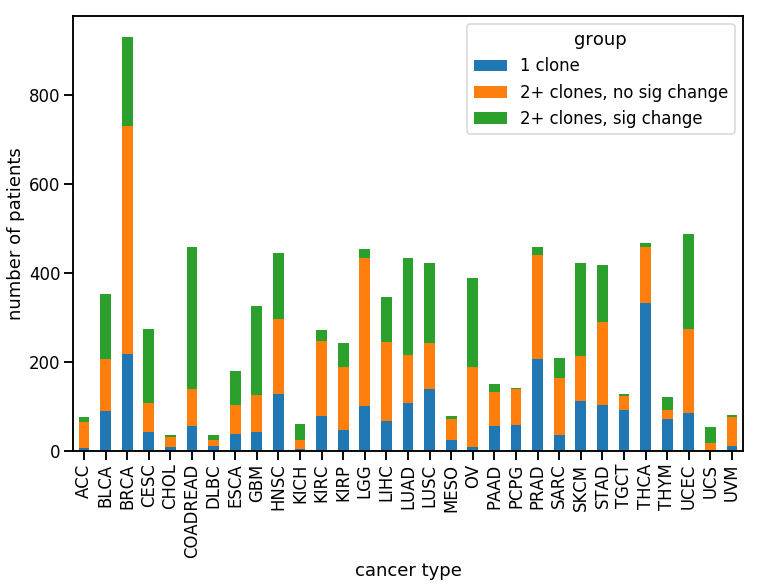

In [8]:

ax=clonesig_res_all_protected.pivot_table(index='cancer_loc_x', columns='group', values='nb_clones', aggfunc='count').plot.bar(stacked=True, figsize=(12, 8))
ax.set_ylabel('number of patients')
ax.set_xlabel('cancer type')
plt.savefig('20190801_paper_figures/overview_cancertype_repartition.pdf', bbox_inches='tight')


group,1 clone,"2+ clones, no sig change","2+ clones, sig change"
cancer_loc_x,,,
ACC,0.090909,0.753247,0.155844
BLCA,0.254237,0.330508,0.415254
BRCA,0.235231,0.549946,0.214823
CESC,0.152727,0.236364,0.610909
CHOL,0.285714,0.600000,0.114286
COADREAD,0.124454,0.181223,0.694323
DLBC,0.324324,0.324324,0.351351
ESCA,0.216667,0.361111,0.422222
GBM,0.128440,0.253823,0.617737


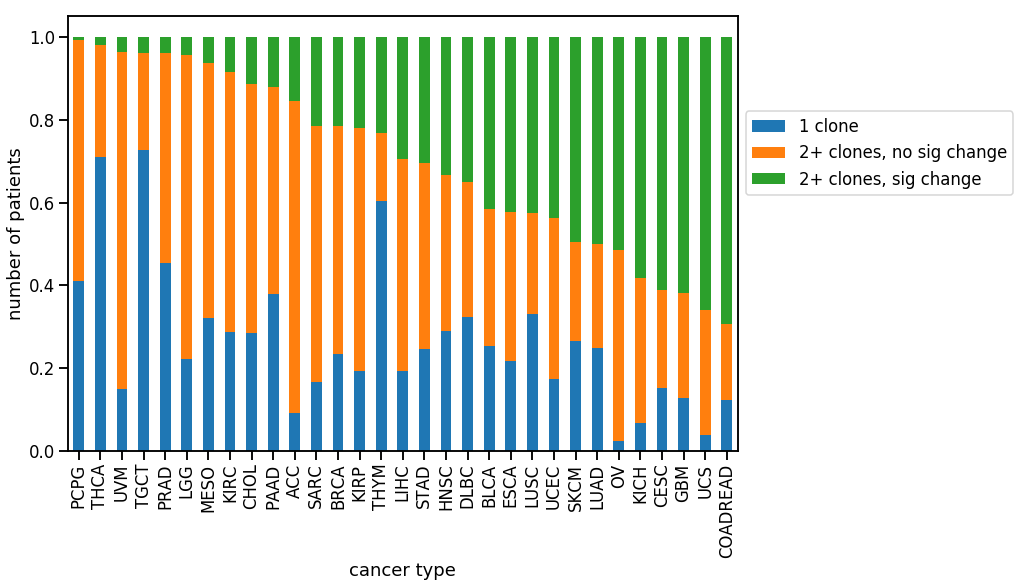

In [29]:
sns.set_context('talk')
norm_table = pd.crosstab(clonesig_res_all_protected.group, clonesig_res_all_protected.cancer_loc_x, normalize='columns').T.sort_values(by='2+ clones, sig change')

ax=norm_table.plot.bar(stacked=True, figsize=(12, 8))
ax.set_ylabel('number of patients')
ax.set_xlabel('cancer type')
ax.legend(loc=2, bbox_to_anchor=(1, 0.8))
plt.savefig('20190801_paper_figures/overview_cancertype_repartition_norm.pdf', bbox_inches='tight')


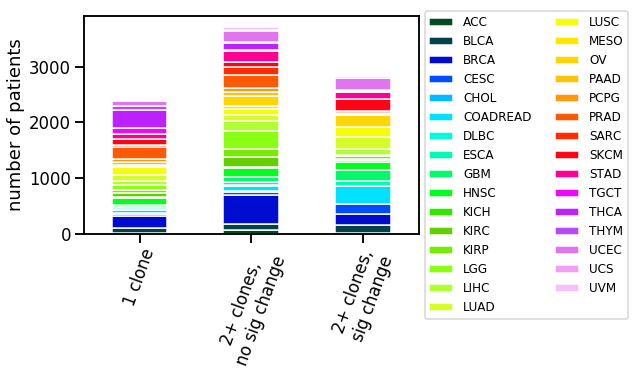

In [7]:
import matplotlib.colors as colors
def truncate_colormap(cmap, minval=0.0, maxval=1.0, n=100):
    new_cmap = colors.LinearSegmentedColormap.from_list(
        'trunc({n},{a:.2f},{b:.2f})'.format(n=cmap.name, a=minval, b=maxval),
        cmap(np.linspace(minval, maxval, n)))
    return new_cmap


cmap = plt.get_cmap('gist_ncar')
new_cmap = truncate_colormap(cmap, 0.04, 0.95)
sns.set_context('talk')
ax=clonesig_res_all_protected.pivot_table(index='cancer_loc_x', columns='group', values='nb_clones', aggfunc='count').T.plot.bar(stacked=True, colormap=new_cmap, edgecolor='white')
plt.legend(loc=2, bbox_to_anchor=(1, 1.05), ncol=2, fontsize=12)
labels = [item.get_text() for item in ax.get_xticklabels()]
labels[1] = '2+ clones,\nno sig change'
labels[2] = '2+ clones,\nsig change'

ax.set_xticklabels(labels)
ax.xaxis.set_tick_params(rotation=70)
ax.set_xlabel('')
ax.set_ylabel('number of patients')
plt.savefig('20190801_paper_figures/overview_cancertype_repartition_bis.pdf', bbox_inches='tight')


In [22]:
clonesig_res_all_protected.pivot_table(index='cancer_loc_x', columns='group', values='binary_vital_status', aggfunc='sum')

group,1 clone,"2+ clones, no sig change","2+ clones, sig change"
cancer_loc_x,,,
ACC,4.0,17.0,6.0
BLCA,44.0,46.0,63.0
BRCA,27.0,69.0,30.0
CESC,13.0,18.0,36.0
CHOL,2.0,10.0,3.0
COADREAD,15.0,16.0,62.0
DLBC,1.0,2.0,2.0
ESCA,18.0,25.0,32.0
GBM,29.0,56.0,161.0


In [23]:
clonesig_res_all_protected.groupby("group").binary_vital_status.sum()

group
1 clone                      547.0
2+ clones, no sig change    1001.0
2+ clones, sig change        971.0
Name: binary_vital_status, dtype: float64

In [24]:
clonesig_res_all_protected.groupby("group").binary_vital_status.count()

group
1 clone                     2296
2+ clones, no sig change    3551
2+ clones, sig change       2778
Name: binary_vital_status, dtype: int64

And finally an overview of which signatures change the most in each cancer type
## Signature change trends by cancer type

ACC
BLCA
BRCA
CESC
CHOL
COADREAD
DLBC
ESCA
GBM
HNSC
KICH
KIRC
KIRP
LGG
LIHC
LUAD
LUSC
MESO
OV
PAAD
PCPG
PRAD
SARC
SKCM
STAD
TGCT
THCA
THYM
UCEC
UCS
UVM


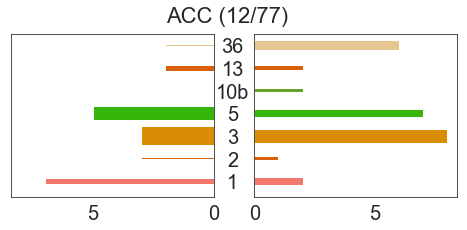

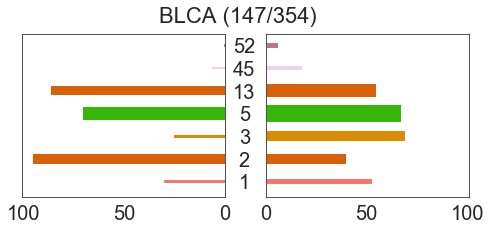

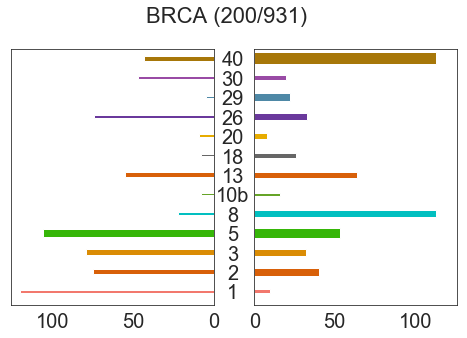

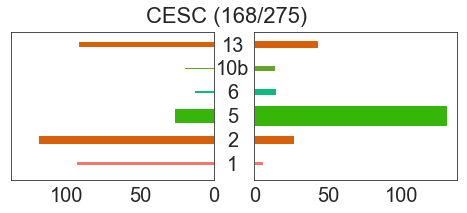

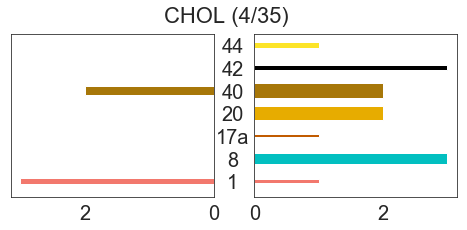

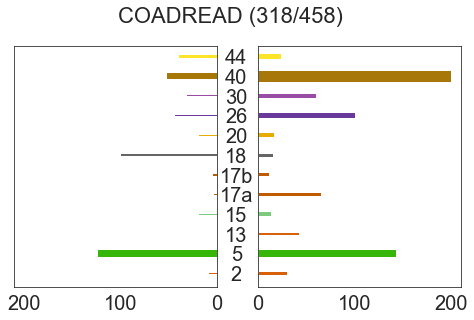

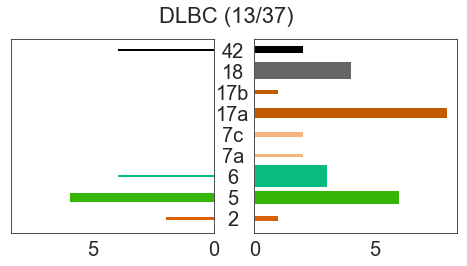

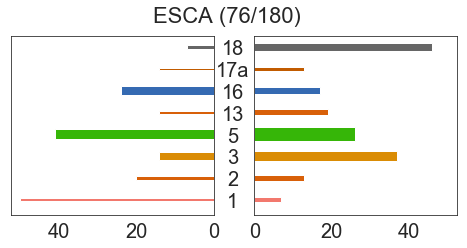

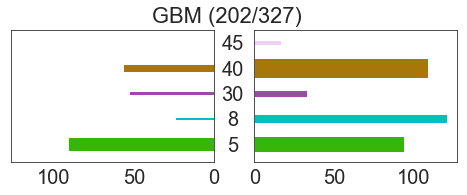

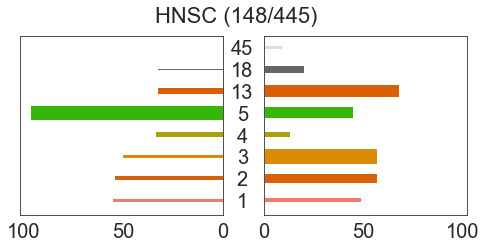

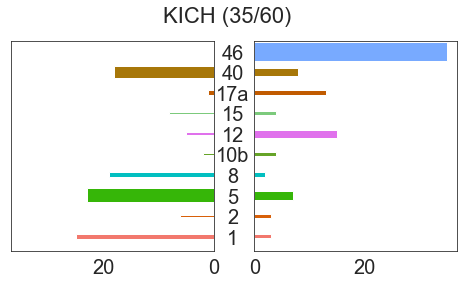

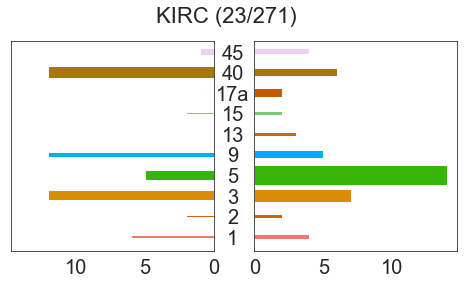

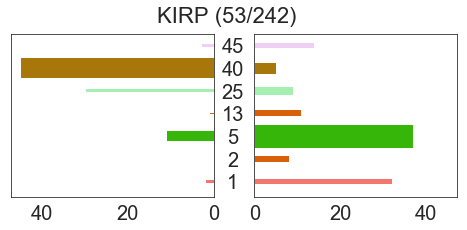

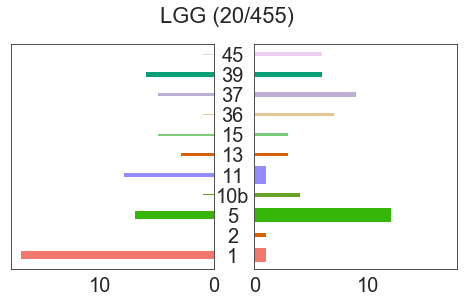

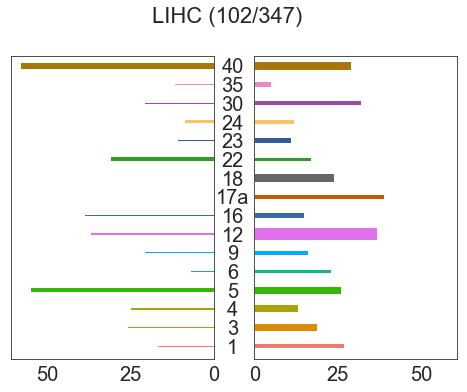

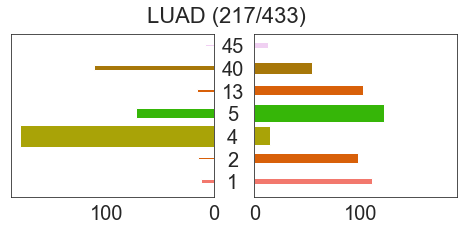

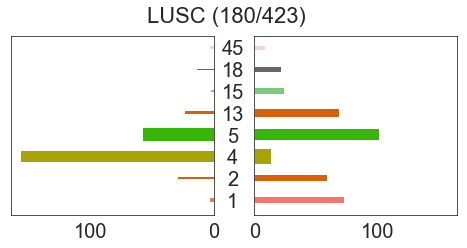

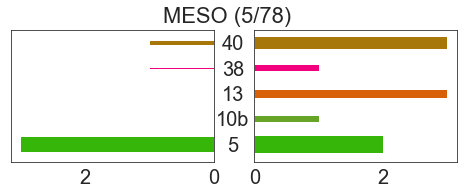

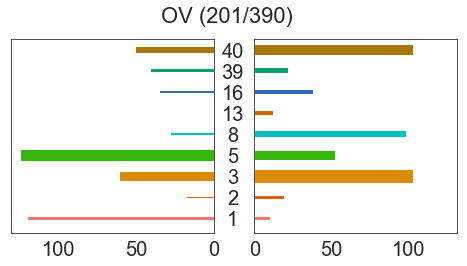

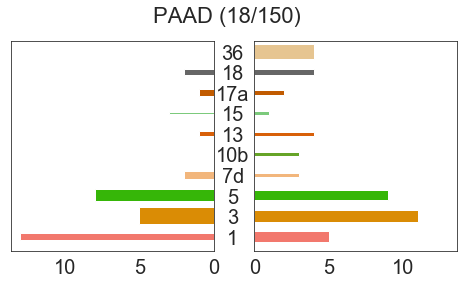

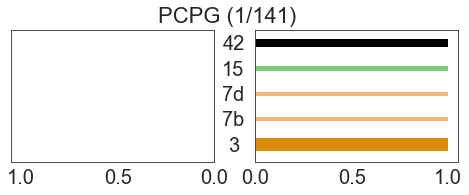

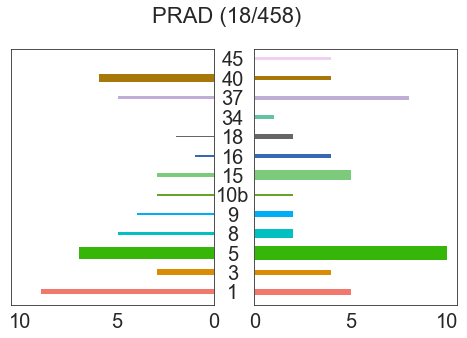

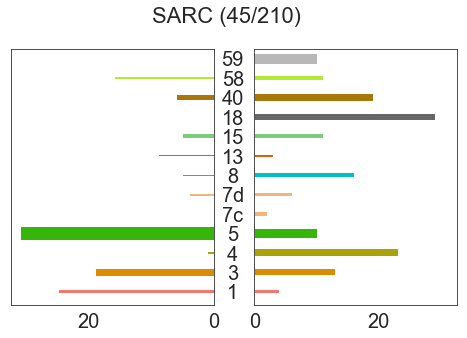

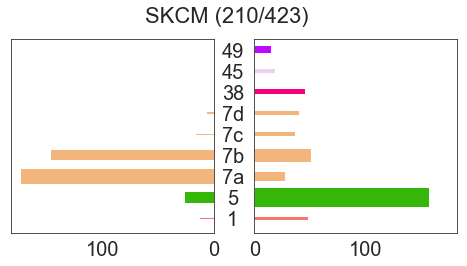

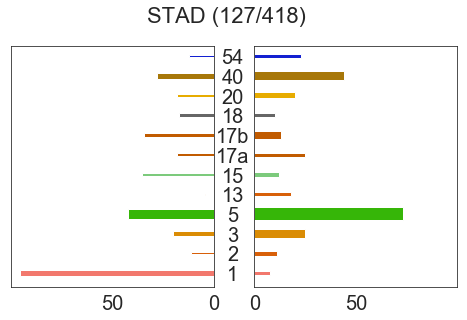

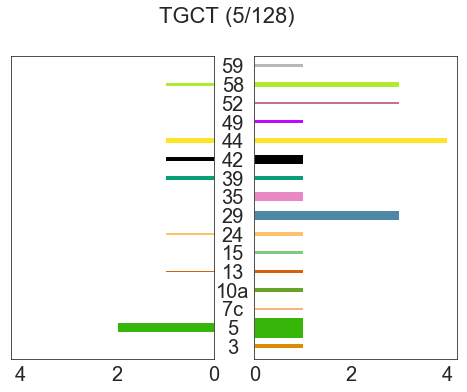

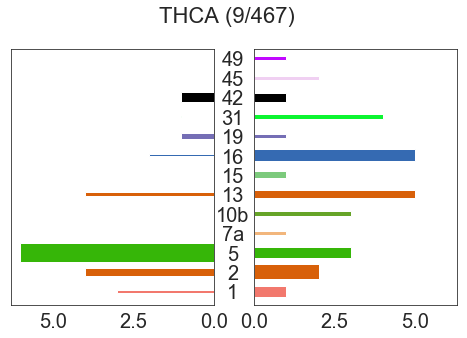

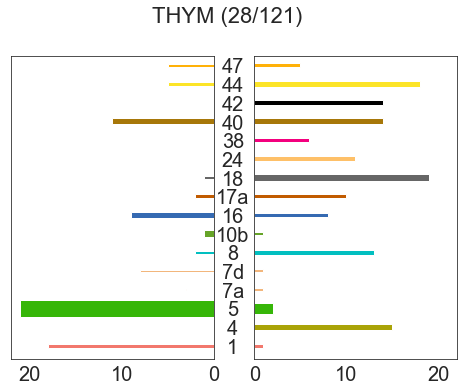

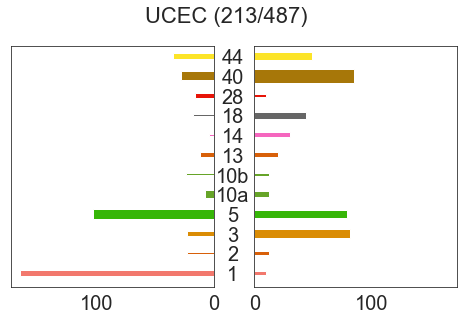

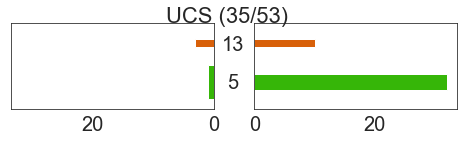

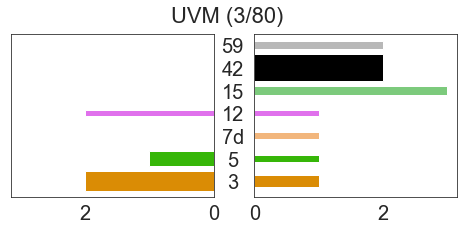

In [14]:
color_dict = collections.OrderedDict()
color_dict['SBS1']= '#F2786D'
color_dict['SBS2']= '#D86009'
color_dict['SBS13']= '#D86009'
color_dict['SBS3']= '#DA8C05'
color_dict['SBS4']= '#A9A307'
color_dict['SBS5']= '#36B608'
color_dict['SBS6']= '#07BC7C'
color_dict['SBS7a']= '#f2b67c'
color_dict['SBS7b']= '#f2b67c'
color_dict['SBS7c']= '#f2b67c'
color_dict['SBS7d']= '#f2b67c'
color_dict['SBS8']= '#02BFC0'
color_dict['SBS9']= '#00AEF7'
color_dict['SBS10a']= '#66A428'
color_dict['SBS10b']= '#66A428'
color_dict['SBS11']= '#938CFF'
color_dict['SBS12']= '#E071EC'
color_dict['SBS14']= '#F566BE'
color_dict['SBS15']= '#7CCA7C'
color_dict['SBS16']= '#356AB2'
color_dict['SBS17a']= '#C15B00'
color_dict['SBS17b']= '#C15B00'
color_dict['SBS18']= '#666666'
color_dict['SBS19']= '#756EB5'
color_dict['SBS20']= '#E7AC00'
color_dict['SBS21']= '#A5CEE4'
color_dict['SBS22']= '#2CA121'
color_dict['SBS23']= '#335a9c'
color_dict['SBS24']= '#FEC068'
color_dict['SBS25']= '#a5f0b1'
color_dict['SBS26']= '#6A399C'
color_dict['SBS28']= '#E71408'
color_dict['SBS29']= '#4e88a6'
color_dict['SBS30']= '#994BA5'
color_dict['SBS31']= '#0cf531'
color_dict['SBS33']= '#A75620'
color_dict['SBS34']= '#62C3A4'
color_dict['SBS35']= '#E988C4'
color_dict['SBS36']= '#E6C591'
color_dict['SBS37']= '#BEADD5'
color_dict['SBS38']= '#F3007E'
color_dict['SBS39']= '#089F76'
color_dict['SBS40']= '#A77709'
color_dict['SBS41']= '#a80526'
color_dict['SBS42']= 'black'
color_dict['SBS43']= '#6b088a'
color_dict['SBS44']= '#fce428'
color_dict['SBS45']= '#f0d0f2'
color_dict['SBS46']= '#78aaff'
color_dict['SBS47']= '#ffb108'
color_dict['SBS49']= '#c108ff'
color_dict['SBS52']= '#c27289'
color_dict['SBS54']= '#1320d1'
color_dict['SBS56']= '#e8dba2'
color_dict['SBS58']= '#b0eb31'
color_dict['SBS59']= '#b8b8b8'

sns.set_style('white')
for loc in clonesig_res.cancer_loc_x.unique():
    print(loc)
    sub_protected_chg = clonesig_res[(clonesig_res.mutation_set=='protected')&(clonesig_res.pval<0.05) & (clonesig_res.cancer_loc_x==loc)]#&(clonesig_res.nb_mut>200)&(clonesig_res.purity>0.4)]
    sbs_names = [c.split('_')[1] for c in sub_protected_chg if 'subclonal_SBS' in c]
    bla = pd.DataFrame(sub_protected_chg[[c for c in sub_protected_chg if 'subclonal_SBS' in c]].fillna(0).values - sub_protected_chg[[c for c in sub_protected_chg if ('clonal_SBS' in c) and ("sub" not in c)]].fillna(0).values, columns=sbs_names)

    final_table = bla[[c for i, c in enumerate(bla.columns) if np.abs(bla).sum(axis=0)[c]>0]]
    final_table[np.abs(final_table)<0.05] = 0
    final_table = final_table[[c for i, c in enumerate(final_table.columns) if np.abs(final_table>0).sum(axis=0)[c]>0.03*len(final_table)]]
    (final_table>0).sum(axis=0)
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(8, final_table.shape[1]/3.5+1))
    plt.subplots_adjust(wspace = 0.2)
    axes[1].barh(y=np.arange(final_table.shape[1]), width=(final_table>0).sum(axis=0).to_frame().T.values[0], color=[color_dict[c] for c in (final_table>0).sum(axis=0).to_frame().T.columns], height= final_table[final_table>0].median(axis=0)*2+0.05)
    axes[0].barh(y=np.arange(final_table.shape[1]), width=(final_table<0).sum(axis=0).to_frame().T.values[0], color=[color_dict[c] for c in (final_table<0).sum(axis=0).to_frame().T.columns],  height= final_table[final_table<0].median(axis=0)*2+0.05)
    axes[0].invert_xaxis()

    fig.suptitle('{} ({}/{})'.format(sub_protected_chg.cancer_loc_x.unique()[0], len(sub_protected_chg), len(clonesig_res[(clonesig_res.mutation_set=='protected') & (clonesig_res.cancer_loc_x==loc)])), fontsize=22,y=1 + 0.05/final_table.shape[1])
    axes[1].set_yticks(range(len(final_table.columns)))
    axes[1].get_yaxis().set_tick_params(pad=18)
    axes[1].set_yticklabels([c.replace('SBS', '') for c in final_table.columns.tolist()], fontsize=20, ha='center')
    axes[0].set_ylim([-0.7, final_table.shape[1]-0.5])
    axes[1].set_ylim([-0.7, final_table.shape[1]-0.5])
    axes[0].set_yticks([])
    axes[1].tick_params(axis="x", labelsize=20)
    axes[0].tick_params(axis="x", labelsize=20)
    max_x = max([axes[1].get_xlim()[1], axes[0].get_xlim()[0]])
    axes[0].set_xlim([max_x, 0])
    axes[1].set_xlim([0, max_x])
    plt.savefig('20190801_paper_figures/{}_sig_trend.pdf'.format(loc), bbox_inches='tight')


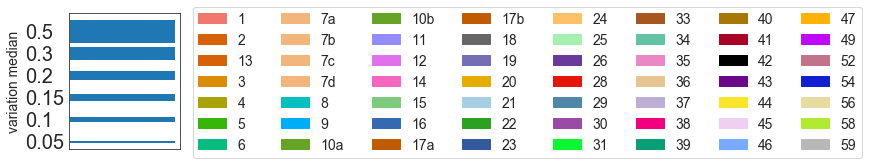

In [15]:

plt.figure(figsize=(2,6.0/4+1))
plt.barh(y=np.arange(6), width=[5]*6 , height=np.array([0.05, 0.1, 0.15, 0.2, 0.3, 0.5]) *2+0.05)
#axes[0].barh(y=np.arange(final_table.shape[1]), width=(final_table<0).sum(axis=0).to_frame().T.values[0], color=[color_dict[c] for c in (final_table<0).sum(axis=0).to_frame().T.columns],  height= final_table[final_table<0].median(axis=0)+0.05)
plt.gca().get_yaxis().set_tick_params(pad=40)
plt.gca().set_yticks(range(6))
plt.gca().set_yticklabels([str(np.round(i, 2)) for i in [0.05, 0.1, 0.15, 0.2, 0.3, 0.5]], fontsize=20, ha='left')
plt.gca().set_xticklabels([])
plt.gca().set_ylabel('variation median', fontsize=14)

patchList = []
for key in color_dict.keys():
        data_key = Patch(color=color_dict[key], label=key.replace('SBS', ''))
        patchList.append(data_key)

plt.legend(handles=patchList, loc=2, bbox_to_anchor=(1.05, 1.1), ncol=8, fontsize=14)
plt.savefig('20190801_paper_figures/legend_sig_trend.pdf'.format(loc), bbox_inches='tight')


In [16]:
final_table[final_table<0].median(axis=0)*2+0.05

SBS3    -0.876379
SBS5    -0.636302
SBS7d         NaN
SBS12   -0.284199
SBS15         NaN
SBS42         NaN
SBS59         NaN
dtype: float64